In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

In [ ]:
# Load dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        #  1 channel -> 32 filters
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        #  32 channels -> 64 filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        #  we have 64 * 7 * 7 = 3136 features
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [ ]:
model = SimpleCNN().to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [ ]:
def validate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [ ]:
num_epochs = 10
train_losses = []
train_accs = []
test_losses = []
test_accs = []

print("\nStarted training")
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = validate(model, test_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%')

print("training complete")


Started training
Epoch [1/10] | Train Loss: 0.2296 | Train Acc: 93.00% | Test Loss: 0.0425 | Test Acc: 98.52%


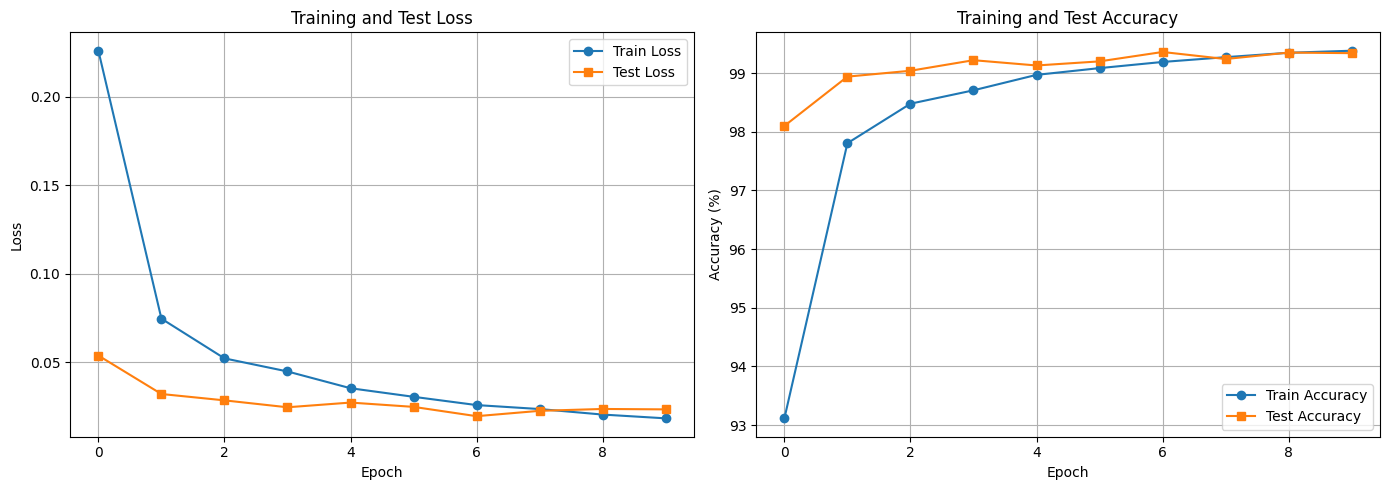

In [ ]:
#plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# Loss plot
axes[0].plot(train_losses, label='Train Loss', marker='o')
axes[0].plot(test_losses, label='Test Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Test Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(train_accs, label='Train Accuracy', marker='o')
axes[1].plot(test_accs, label='Test Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Test Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


Testing on sample images...


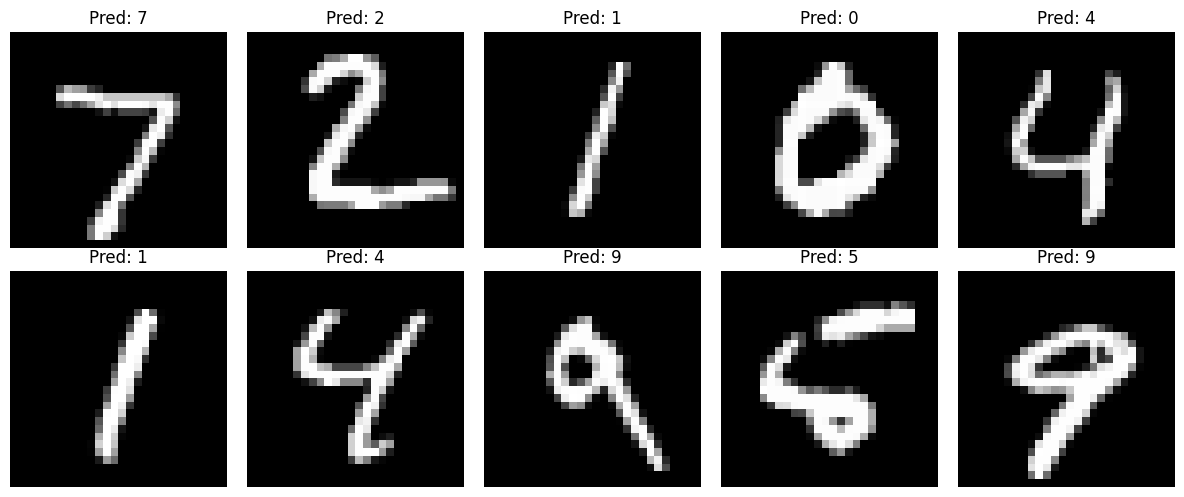

In [ ]:
print("\nTesting on sample images...")
model.eval()
with torch.no_grad():
    images, labels = next(iter(test_loader))
    images = images[:10].to(device)  # First 10 images
    
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    for i in range(10):
        ax = axes[i // 5, i % 5]
        img = images[i].cpu().squeeze()
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Pred: {predicted[i].item()}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
final_loss, final_acc = validate(model, test_loader, criterion, device)
print(f"\nFinal Test Loss: {final_loss:.4f}")
print(f"Final Test Accuracy: {final_acc:.2f}%")


Final Test Loss: 0.0232
Final Test Accuracy: 99.34%
